In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import dataframe_image as dfi

In [2]:
tval_summary = glob.glob('../logging/26-02-2024_1922/*_train_val_summary',recursive=True)

In [3]:
output_list = ['Function','Role','Level']
epoch_stats = []
loss_training = []
loss_validation = []
accuracy_training = {}
accuracy_validation = {}
for output in output_list:
    accuracy_training[output] = []
    accuracy_validation[output] = []
for epoch_path in tval_summary:
    with open(epoch_path,'rb') as file:
        this_file = pickle.load(file)
        epoch_stats.append(this_file[-1])
        loss_training.append(this_file[-1]['training_loss'])
        loss_validation.append(this_file[-1]['validation_loss'])
        for output in output_list:
            accuracy_training[output].append(this_file[-1]['training_accuracy'][output])
            accuracy_validation[output].append(this_file[-1]['validation_accuracy'][output])

for output in output_list:
    accuracy_training[output] = np.array(accuracy_training[output])
    accuracy_validation[output] = np.array(accuracy_validation[output])
loss_training = np.array(loss_training)
loss_validation = np.array(loss_validation)
epochs = np.arange(1,21,1)

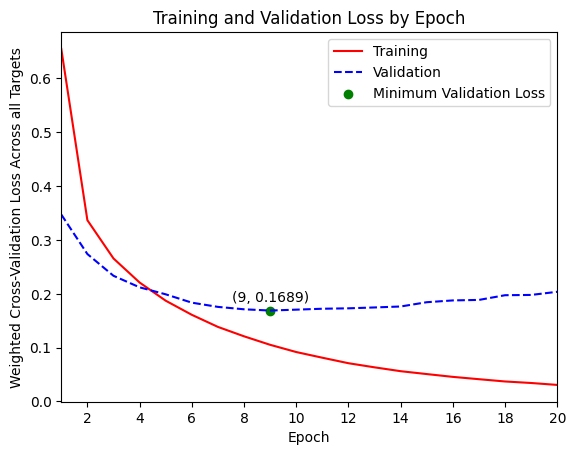

In [4]:
min_epoch = loss_validation.argmin() + 1
min_val = loss_validation.min()
f,ax = plt.subplots()
ax.plot(epochs,loss_training, label = 'Training',linestyle = '-',color = 'red')
ax.plot(epochs,loss_validation, label = 'Validation',linestyle = '--',color = 'blue')
plt.xlim(epochs.min(),epochs.max())
ax.set_xticks(np.arange(2,21,2))
ax.scatter(min_epoch,min_val,
           label = 'Minimum Validation Loss'.format(min_val),color = 'green')
ax.text(min_epoch,min_val+.01,'({:.0f}, {:.4f})'.format(min_epoch,min_val),
        horizontalalignment = 'center',verticalalignment = 'bottom')
ax.set_title('Training and Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Weighted Cross-Validation Loss Across all Targets')
ax.legend()

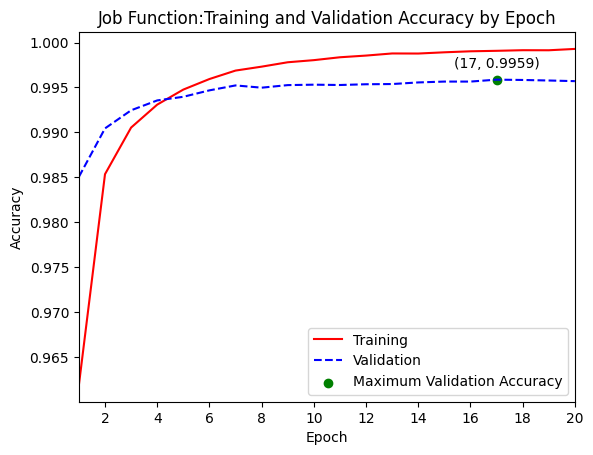

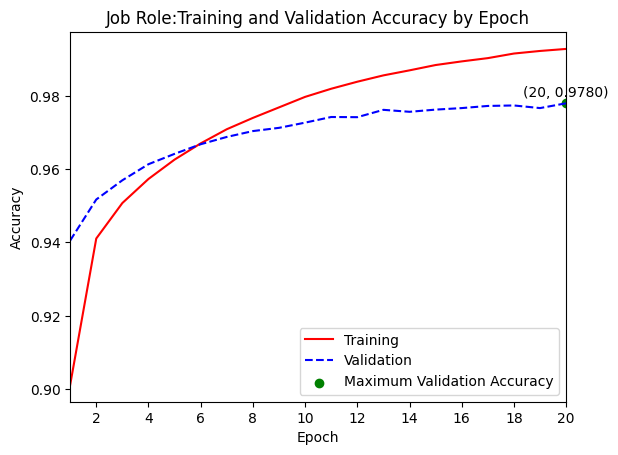

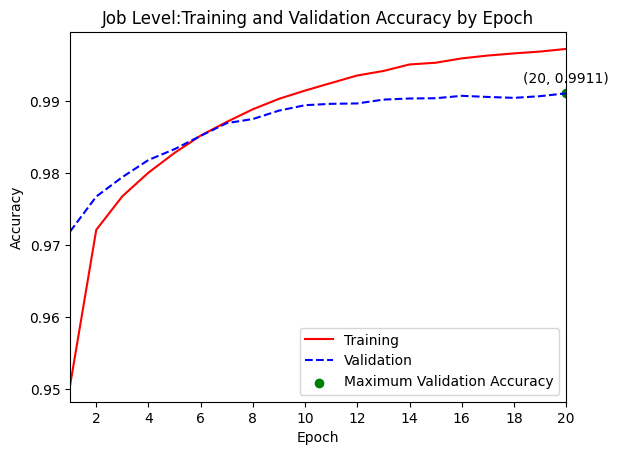

In [5]:
for output in output_list:
        this_min_epoch = accuracy_validation[output].argmax()+1
        min_val = accuracy_validation[output].max()
        f,ax = plt.subplots()
        ax.plot(epochs,accuracy_training[output], label = 'Training',linestyle = '-',color = 'red')
        ax.plot(epochs,accuracy_validation[output], label = 'Validation',linestyle = '--',color = 'blue')
        plt.xlim(epochs.min(),epochs.max())
        ax.set_xticks(np.arange(2,21,2))
        ax.scatter(this_min_epoch,min_val,
                label = 'Maximum Validation Accuracy'.format(min_val),color = 'green')
        ax.text(this_min_epoch,min_val+.001,'({:.0f}, {:.4f})'.format(this_min_epoch,min_val),
                horizontalalignment = 'center',verticalalignment = 'bottom')
        ax.set_title('Job {}:Training and Validation Accuracy by Epoch'.format(output))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        ax.legend()

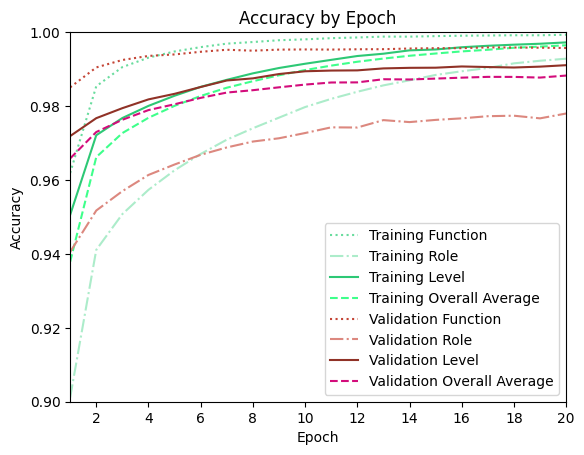

In [6]:
avg_overall_accuracy_training = np.array(list(accuracy_training.values())).mean(axis = 0)
avg_overall_accuracy_validation = np.array(list(accuracy_validation.values())).mean(axis = 0)
f,ax = plt.subplots()
ax.plot(epochs,accuracy_training['Function'], label = 'Training Function',linestyle = 'dotted',color = '#69DC9E')
ax.plot(epochs,accuracy_training['Role'], label = 'Training Role',linestyle = 'dashdot',color = '#ACECCA')
ax.plot(epochs,accuracy_training['Level'], label = 'Training Level',linestyle = '-',color = '#2DC875')
ax.plot(epochs,avg_overall_accuracy_training, label = 'Training Overall Average',linestyle = '--',color = '#3EFF8B')
ax.plot(epochs,accuracy_validation['Function'], label = 'Validation Function',linestyle = 'dotted',color = '#C44536')
ax.plot(epochs,accuracy_validation['Role'], label = 'Validation Role',linestyle = 'dashdot',color = '#DC887F')
ax.plot(epochs,accuracy_validation['Level'], label = 'Validation Level',linestyle = '-',color = '#903227')
ax.plot(epochs,avg_overall_accuracy_validation, label = 'Validation Overall Average',linestyle = '--',color = '#D30C7B')
plt.xlim(epochs.min(),epochs.max())
plt.ylim(0.9,1)
ax.set_xticks(np.arange(2,21,2))
ax.set_title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()

In [7]:
with open('../Data/index_label_mapping.pkl','rb') as file:
    index_label_mapping = pickle.load(file)

In [8]:
index_label_mapping

{'Job Role': {0: 'DEVELOPMENT',
  1: 'GOVERNANCE RISK COMPLIANCE',
  2: 'INFORMATION SECURITY',
  3: 'IT GENERAL',
  4: 'NETWORKING',
  5: 'NON-ICP',
  6: 'SYSTEMS'},
 'Job Function': {0: 'ENGINEERING',
  1: 'IT',
  2: 'NON-ICP',
  3: 'PROCUREMENT',
  4: 'RISK/LEGAL/COMPLIANCE'},
 'Job Level': {0: 'C-LEVEL',
  1: 'CONTRIBUTOR',
  2: 'DIRECTOR',
  3: 'EXECUTIVE',
  4: 'MANAGER',
  5: 'UNKNOWN'}}

In [9]:
conf_mat_labeled = {}
for output in output_list:
    this_mapping = index_label_mapping['Job {}'.format(output)]
    this_df = pd.DataFrame(epoch_stats[min_epoch-1]['validation_conf_mat'][output].numpy().astype(int))
    new_index = [this_mapping[index] for index in this_df.index]
    new_columns = [this_mapping[column] for column in this_df.columns]
    this_df.columns = [["Actual"]*len(new_columns),new_columns]
    this_df.index = [["Predicted"]*len(new_index),new_index]
    conf_mat_labeled[output] = this_df

In [10]:
for output in output_list:
    print('Job {}'.format(output))
    display(conf_mat_labeled[output])
    display(conf_mat_labeled[output].sum().sum())
    print('Accuracy: {:.4f}'.format(accuracy_validation[output][min_epoch-1]))
    this_correct = np.diag(conf_mat_labeled[output].values)
    precision = this_correct/conf_mat_labeled[output].values.sum(axis = 1)
    recall = this_correct/conf_mat_labeled[output].values.sum(axis = 0)
    F1 = (2 * precision * recall)/(precision + recall)
    for _,pred_class in enumerate(conf_mat_labeled[output].columns):
        this_class = pred_class[1]
        print('F1 Score for {}: {:.4f}'.format(this_class,F1[_]))
    print('Global Average F1: {:.4f}'.format(F1.mean()))
    print('Column Sums')
    print(conf_mat_labeled[output].values.sum(axis = 0))
    print('Row Sums')
    print(conf_mat_labeled[output].values.sum(axis = 1))

Job Function


Actual                             \
                                ENGINEERING     IT NON-ICP PROCUREMENT   
Predicted ENGINEERING                  7899     24      27           0   
          IT                             23  59028     173           1   
          NON-ICP                        32     96   16001           1   
          PROCUREMENT                     1      2       9         245   
          RISK/LEGAL/COMPLIANCE           0      4       2           0   

                                                       
                                RISK/LEGAL/COMPLIANCE  
Predicted ENGINEERING                               0  
          IT                                        0  
          NON-ICP                                   2  
          PROCUREMENT                               0  
          RISK/LEGAL/COMPLIANCE                   153

83723

Accuracy: 0.9953
F1 Score for ENGINEERING: 0.9933
F1 Score for IT: 0.9973
F1 Score for NON-ICP: 0.9894
F1 Score for PROCUREMENT: 0.9722
F1 Score for RISK/LEGAL/COMPLIANCE: 0.9745
Global Average F1: 0.9853
Column Sums
[ 7955 59154 16212   247   155]
Row Sums
[ 7950 59225 16132   257   159]
Job Role


Actual                             \
                                     DEVELOPMENT GOVERNANCE RISK COMPLIANCE   
Predicted DEVELOPMENT                       7941                          7   
          GOVERNANCE RISK COMPLIANCE           2                       1965   
          INFORMATION SECURITY                45                         33   
          IT GENERAL                          39                          6   
          NETWORKING                          55                         11   
          NON-ICP                             39                         14   
          SYSTEMS                             14                          1   

                                                                      \
                                     INFORMATION SECURITY IT GENERAL   
Predicted DEVELOPMENT                                  28         60   
          GOVERNANCE RISK COMPLIANCE                   72         18   
          INFORMATION SECURITY                      26668        236   
          IT GENERAL                                  114       3894   
          NETWORKING                                  250        168   
          NON-ICP                                      96         74   
          SYSTEMS                                      35         31   

                                                                 
                                     NETWORKING NON-ICP SYSTEMS  
Predicted DEVELOPMENT                        47      72      19  
          GOVERNANCE RISK COMPLIANCE         11      18       5  
          INFORMATION SECURITY              119     106      52  
          IT GENERAL                         97      55      26  
          NETWORKING                      21304     137      37  
          NON-ICP                           103   18193      24  
          SYSTEMS                            11      21    1350

83723

Accuracy: 0.9713
F1 Score for DEVELOPMENT: 0.9738
F1 Score for GOVERNANCE RISK COMPLIANCE: 0.9520
F1 Score for INFORMATION SECURITY: 0.9782
F1 Score for IT GENERAL: 0.8939
F1 Score for NETWORKING: 0.9760
F1 Score for NON-ICP: 0.9796
F1 Score for SYSTEMS: 0.9073
Global Average F1: 0.9516
Column Sums
[ 8135  2037 27263  4481 21692 18602  1513]
Row Sums
[ 8174  2091 27259  4231 21962 18543  1463]
Job Level


Actual                                               
                      C-LEVEL CONTRIBUTOR DIRECTOR EXECUTIVE MANAGER UNKNOWN
Predicted C-LEVEL        9659          13        6        31       7       8
          CONTRIBUTOR      23       30518       72        60      65     110
          DIRECTOR         10          67    14103        40      17       7
          EXECUTIVE        63          38       28     10982      11      23
          MANAGER           7         129       28         8   17372      41
          UNKNOWN           3          28        0         5       3     138

83723

Accuracy: 0.9887
F1 Score for C-LEVEL: 0.9912
F1 Score for CONTRIBUTOR: 0.9902
F1 Score for DIRECTOR: 0.9903
F1 Score for EXECUTIVE: 0.9862
F1 Score for MANAGER: 0.9910
F1 Score for UNKNOWN: 0.5476
Global Average F1: 0.9161
Column Sums
[ 9765 30793 14237 11126 17475   327]
Row Sums
[ 9724 30848 14244 11145 17585   177]


In [11]:
# Now to pull in the test set
with open('../test/27-02-2024_1408/test_summary','rb') as file:
    test_summary = pickle.load(file)

In [12]:
test_conf_mat_labeled = {}
print('Test Loss: {:.4f}'.format(test_summary['test_loss']))
for output in output_list:
    this_mapping = index_label_mapping['Job {}'.format(output)]
    this_df = pd.DataFrame(test_summary['test_conf_mat'][output].numpy().astype(int))
    new_index = [this_mapping[index] for index in this_df.index]
    new_columns = [this_mapping[column] for column in this_df.columns]
    this_df.columns = [["Actual"]*len(new_columns),new_columns]
    this_df.index = [["Predicted"]*len(new_index),new_index]
    test_conf_mat_labeled[output] = this_df
    print('Job {}'.format(output))
    print('Accuracy: {:.4f}'.format(test_summary['test_accuracy'][output]))
    display(this_df)
    dfi.export(this_df, '../Reports/ConfMat_{}.png'.format(output))
    this_correct_test = np.diag(this_df.values)
    precision_test = this_correct_test/this_df.values.sum(axis = 1)
    recall_test = this_correct_test/this_df.values.sum(axis = 0)
    F1_test = (2 * precision_test * recall_test)/(precision_test + recall_test)
    for _,pred_class_test in enumerate(this_df.columns):
        this_class_test = pred_class_test[1]
        print('F1 Score for {}: {:.4f}'.format(this_class_test,F1_test[_]))
    print('Global Average F1: {:.4f}'.format(F1_test.mean()))
    print('Column Sums')
    print(this_df.values.sum(axis = 0))
    print('Row Sums')
    print(this_df.values.sum(axis = 1))

Test Loss: 0.1724
Job Function
Accuracy: 0.9955


Actual                             \
                                ENGINEERING     IT NON-ICP PROCUREMENT   
Predicted ENGINEERING                  7870     16      23           0   
          IT                             31  59138     169           1   
          NON-ICP                        20     97   15947           1   
          PROCUREMENT                     2      0       6         241   
          RISK/LEGAL/COMPLIANCE           0      2       2           0   

                                                       
                                RISK/LEGAL/COMPLIANCE  
Predicted ENGINEERING                               0  
          IT                                        2  
          NON-ICP                                   3  
          PROCUREMENT                               0  
          RISK/LEGAL/COMPLIANCE                   153

F1 Score for ENGINEERING: 0.9942
F1 Score for IT: 0.9973
F1 Score for NON-ICP: 0.9900
F1 Score for PROCUREMENT: 0.9797
F1 Score for RISK/LEGAL/COMPLIANCE: 0.9714
Global Average F1: 0.9865
Column Sums
[ 7923 59253 16147   243   158]
Row Sums
[ 7909 59341 16068   249   157]
Job Role
Accuracy: 0.9719


Actual                             \
                                     DEVELOPMENT GOVERNANCE RISK COMPLIANCE   
Predicted DEVELOPMENT                       8036                          2   
          GOVERNANCE RISK COMPLIANCE           2                       1984   
          INFORMATION SECURITY                42                         40   
          IT GENERAL                          47                          8   
          NETWORKING                          61                         12   
          NON-ICP                             39                          5   
          SYSTEMS                             13                          1   

                                                                      \
                                     INFORMATION SECURITY IT GENERAL   
Predicted DEVELOPMENT                                  43         64   
          GOVERNANCE RISK COMPLIANCE                   85         18   
          INFORMATION SECURITY                      26544        236   
          IT GENERAL                                   92       3950   
          NETWORKING                                  241        167   
          NON-ICP                                     100         93   
          SYSTEMS                                      26         30   

                                                                 
                                     NETWORKING NON-ICP SYSTEMS  
Predicted DEVELOPMENT                        51      54      18  
          GOVERNANCE RISK COMPLIANCE          9      15       3  
          INFORMATION SECURITY              121     106      38  
          IT GENERAL                         68      51      31  
          NETWORKING                      21370     120      31  
          NON-ICP                           127   18251      19  
          SYSTEMS                            13      16    1231

F1 Score for DEVELOPMENT: 0.9736
F1 Score for GOVERNANCE RISK COMPLIANCE: 0.9520
F1 Score for INFORMATION SECURITY: 0.9784
F1 Score for IT GENERAL: 0.8972
F1 Score for NETWORKING: 0.9767
F1 Score for NON-ICP: 0.9800
F1 Score for SYSTEMS: 0.9115
Global Average F1: 0.9528
Column Sums
[ 8240  2052 27131  4558 21759 18613  1371]
Row Sums
[ 8268  2116 27127  4247 22002 18634  1330]
Job Level
Accuracy: 0.9875


Actual                                               
                      C-LEVEL CONTRIBUTOR DIRECTOR EXECUTIVE MANAGER UNKNOWN
Predicted C-LEVEL        9554          28       10        38       5       6
          CONTRIBUTOR      21       30861       73        64      69     125
          DIRECTOR         25          63    14067        34      24      16
          EXECUTIVE        54          40       38     10775      11      29
          MANAGER          13         135       28        12   17282      34
          UNKNOWN           7          38        3         0       6     136

F1 Score for C-LEVEL: 0.9893
F1 Score for CONTRIBUTOR: 0.9895
F1 Score for DIRECTOR: 0.9890
F1 Score for EXECUTIVE: 0.9854
F1 Score for MANAGER: 0.9903
F1 Score for UNKNOWN: 0.5075
Global Average F1: 0.9085
Column Sums
[ 9674 31165 14219 10923 17397   346]
Row Sums
[ 9641 31213 14229 10947 17504   190]
